<a href="https://colab.research.google.com/github/sabbas123/Comparing-two-videos-using-keypoints-using-Jaccard-Similarity/blob/main/Comparing_two_videos_using_keypoints_%26_using_Jaccard_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Using Keypoints**

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe solutions
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints_and_pose(pose_results, hands_results):
    """
    Extract specific upper body and hand keypoints from MediaPipe results.
    """
    keypoints = {
        'upper_body': [],
        'left_hand': [],
        'right_hand': []
    }
    # Indices for the upper body parts (customize this list based on your requirement of 23 keypoints)
    upper_body_indices = range(0, 33)  # Adjust this range based on the keypoints you want

    # Extract upper body landmarks
    if pose_results.pose_landmarks:
        for idx, landmark in enumerate(pose_results.pose_landmarks.landmark):
            if idx in upper_body_indices:
                keypoints['upper_body'].append({
                    'x': landmark.x,
                    'y': landmark.y,
                    'z': landmark.z,
                    'visibility': landmark.visibility
                })
    # Extract left and right hand landmarks
    if hands_results.multi_hand_landmarks:
        for i, hand_landmarks in enumerate(hands_results.multi_hand_landmarks):
            hand_type = 'left_hand' if i == 0 else 'right_hand'
            for landmark in hand_landmarks.landmark:
                keypoints[hand_type].append({
                    'x': landmark.x,
                    'y': landmark.y,
                    'z': landmark.z
                })
    return keypoints

def extract_significant_frames_and_keypoints(video_path, save_dir, threshold=0.1):
    """
    Extract significant frames and keypoints (upper body, left hand, right hand) from a video.
    """
    cap = cv2.VideoCapture(video_path)
    prev_pose = None
    frame_idx = 0
    keypoints_data = []

    with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose, \
         mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pose_results = pose.process(image_rgb)
            hands_results = hands.process(image_rgb)

            # Optionally, draw pose and hands on the image for visualization
            annotated_image = image.copy()
            mp_drawing.draw_landmarks(annotated_image, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
            if hands_results.multi_hand_landmarks:
                for hand_landmarks in hands_results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(annotated_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Compare current pose to the previous one to detect significant movement
            if prev_pose and pose_results.pose_landmarks:
                pose_diff = np.sum([abs(a.x - b.x) + abs(a.y - b.y) for a, b in zip(prev_pose.landmark, pose_results.pose_landmarks.landmark)])
                if pose_diff > threshold:
                    frame_save_path = os.path.join(save_dir, f"frame_{frame_idx}.png")
                    cv2.imwrite(frame_save_path, annotated_image)  # Save the annotated image
                    keypoints = extract_keypoints_and_pose(pose_results, hands_results)
                    keypoints_data.append({
                        'frame_id': frame_idx,
                        'frame_name': f"frame_{frame_idx}.png",
                        'keypoints': keypoints
                    })
                    frame_idx += 1

            prev_pose = pose_results.pose_landmarks

    cap.release()
    # Save keypoints to a JSON file with frame ID and name
    keypoints_file_path = os.path.join(save_dir, "keypoints.json")
    with open(keypoints_file_path, 'w') as f:
        json.dump(keypoints_data, f, indent=4)

# Define paths to video files and directories for saving frames/keypoints
video_paths = ["/content/drive/MyDrive/ArSL video dataset/الحمد لله/الحمد لله 1.mp4",
               "/content/drive/MyDrive/ArSL video dataset/الحمد لله/الحمد لله 2.mp4"]
save_dirs = ["/content/drive/MyDrive/video_111", "/content/drive/MyDrive/video_222"]

for video_path, save_dir in zip(video_paths, save_dirs):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    extract_significant_frames_and_keypoints(video_path, save_dir)

Most similar frame pair: Video1 Frame 23 and Video2 Frame 22 with distance 0.07223285175458026


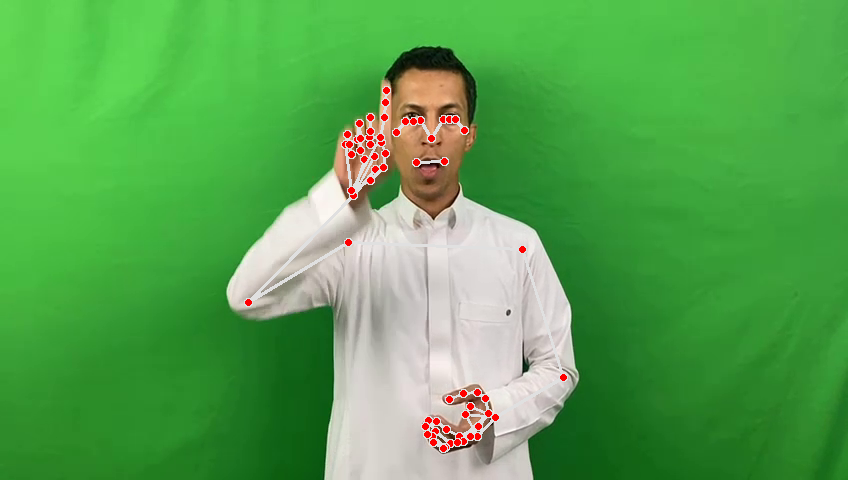

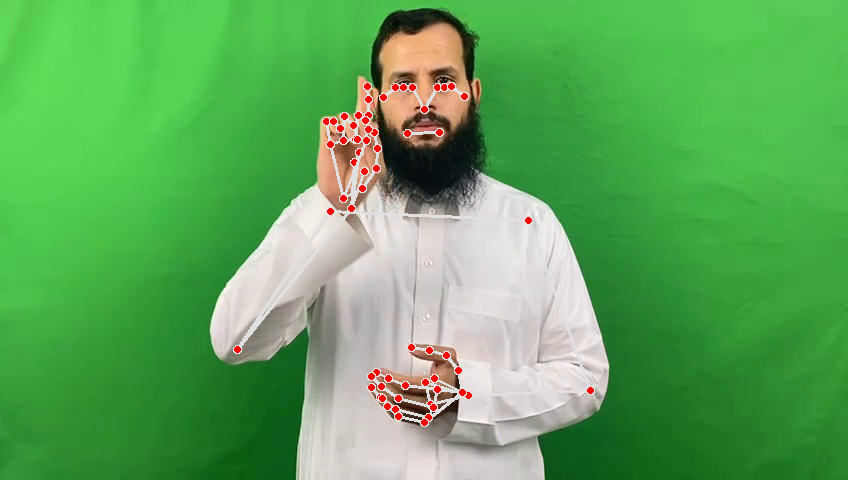

In [ ]:
import os
import json
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def load_keypoints(json_file_path):
    """Load keypoints from a JSON file."""
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def calculate_distance(keypoints1, keypoints2):
    """Calculate Euclidean distance between two sets of keypoints."""
    distance = 0
    count = 0
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:  # For Ensuring both keypoints are not empty
            dist = np.sqrt((kp1['x'] - kp2['x'])**2 + (kp1['y'] - kp2['y'])**2 + (kp1['z'] - kp2['z'])**2)
            distance += dist
            count += 1
    return distance / count if count > 0 else float('inf')

def find_most_similar_frame(keypoints_video1, keypoints_video2):
    """Find the most similar frame in video1 to any frame in video2 based on keypoints."""
    min_distance = float('inf')
    most_similar_pair = (None, None)

    for i, frame1 in enumerate(keypoints_video1):
        for j, frame2 in enumerate(keypoints_video2):
            distance = calculate_distance(frame1['keypoints']['upper_body'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                          frame2['keypoints']['upper_body'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            if distance < min_distance:
                min_distance = distance
                most_similar_pair = (i, j)

    return most_similar_pair, min_distance

# Paths to the JSON files containing keypoints for each video
json_file_path_video1 = '/content/drive/MyDrive/video_111/keypoints.json'
json_file_path_video2 = '/content/drive/MyDrive/video_222/keypoints.json'

keypoints_video1 = load_keypoints(json_file_path_video1)
keypoints_video2 = load_keypoints(json_file_path_video2)

most_similar_pair, min_distance = find_most_similar_frame(keypoints_video1, keypoints_video2)
print(f"Most similar frame pair: Video1 Frame {most_similar_pair[0]} and Video2 Frame {most_similar_pair[1]} with distance {min_distance}")


frame_path_video1 = f"/content/drive/MyDrive/video_111/frame_{most_similar_pair[0]}.png"
frame_path_video2 = f"/content/drive/MyDrive/video_222/frame_{most_similar_pair[1]}.png"

img1 = cv2.imread(frame_path_video1)
img2 = cv2.imread(frame_path_video2)

cv2_imshow(img1)
cv2_imshow(img2)


In [ ]:
import json

def load_keypoints_for_single_frame(json_file_path, frame_index=0):
    """Load keypoints from a JSON file for a single frame."""
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    if len(data) > frame_index:
        frame = data[frame_index]
        pose_keypoints_count = len(frame['keypoints']['upper_body'])
        left_hand_keypoints_count = len(frame['keypoints']['left_hand'])
        right_hand_keypoints_count = len(frame['keypoints']['right_hand'])

        print(f"Frame {frame_index} pose keypoints count: {pose_keypoints_count}")
        print(f"Frame {frame_index} left hand keypoints count: {left_hand_keypoints_count}")
        print(f"Frame {frame_index} right hand keypoints count: {right_hand_keypoints_count}")
    else:
        print(f"No data available for frame index {frame_index}")

# Path to the JSON file
json_file_path = '/content/drive/MyDrive/video_11/keypoints.json'
load_keypoints_for_single_frame(json_file_path, 0)

Frame 0 pose keypoints count: 23
Frame 0 left hand keypoints count: 21
Frame 0 right hand keypoints count: 21


# **الحمد لله**

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe solutions
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints_and_pose(pose_results, hands_results):
    """
    Extract pose, left hand, and right hand keypoints from MediaPipe results.
    """
    keypoints = {
        'pose': [],
        'left_hand': [],
        'right_hand': []
    }
    # Extract pose landmarks
    if pose_results.pose_landmarks:
        for landmark in pose_results.pose_landmarks.landmark:
            keypoints['pose'].append({
                'x': landmark.x,
                'y': landmark.y,
                'z': landmark.z,
                'visibility': landmark.visibility
            })
    # Extract left and right hand landmarks
    if hands_results.multi_hand_landmarks:
        for hand_landmarks in hands_results.multi_hand_landmarks:
            hand_type = 'left_hand' if hand_landmarks == hands_results.multi_hand_landmarks[0] else 'right_hand'
            for landmark in hand_landmarks.landmark:
                keypoints[hand_type].append({
                    'x': landmark.x,
                    'y': landmark.y,
                    'z': landmark.z
                })
    return keypoints

def extract_significant_frames_and_keypoints(video_path, save_dir, threshold=0.1):
    """
    Extract significant frames and keypoints (pose, left hand, right hand) from a video.
    """
    cap = cv2.VideoCapture(video_path)
    prev_pose = None
    frame_idx = 0
    keypoints_data = []

    with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose, \
         mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pose_results = pose.process(image_rgb)
            hands_results = hands.process(image_rgb)

            # Draw pose and hands on the image
            mp_drawing.draw_landmarks(image, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
            if hands_results.multi_hand_landmarks:
                for hand_landmarks in hands_results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            if prev_pose and pose_results.pose_landmarks:
                pose_diff = np.sum([abs(a.x - b.x) + abs(a.y - b.y) for a, b in zip(prev_pose.landmark, pose_results.pose_landmarks.landmark)])
                if pose_diff > threshold:
                    frame_save_path = os.path.join(save_dir, f"frame_{frame_idx}.png")
                    cv2.imwrite(frame_save_path, image)
                    keypoints = extract_keypoints_and_pose(pose_results, hands_results)
                    keypoints_data.append({
                        'frame_id': frame_idx,
                        'frame_name': f"frame_{frame_idx}.png",
                        'keypoints': keypoints
                    })
                    frame_idx += 1

            prev_pose = pose_results.pose_landmarks

    cap.release()
    # Save keypoints to JSON file with frame ID and name
    keypoints_file_path = os.path.join(save_dir, "keypoints.json")
    with open(keypoints_file_path, 'w') as f:
        json.dump(keypoints_data, f, indent=4)

# video files and directories to save frames/keypoints
video_paths = ["/content/drive/MyDrive/ArSL video dataset/الحمد لله/الحمد لله 1.mp4",
               "/content/drive/MyDrive/ArSL video dataset/الحمد لله/الحمد لله 2.mp4"]
save_dirs = ["/content/drive/MyDrive/video_1", "/content/drive/MyDrive/video_2"]

for video_path, save_dir in zip(video_paths, save_dirs):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    extract_significant_frames_and_keypoints(video_path, save_dir)

Most similar frame pair: Video1 Frame 23 and Video2 Frame 22 with distance 0.07223285175458026


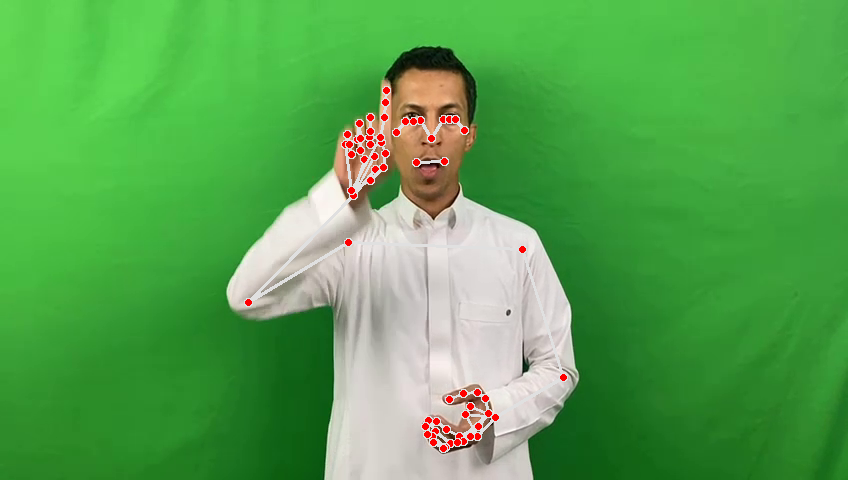

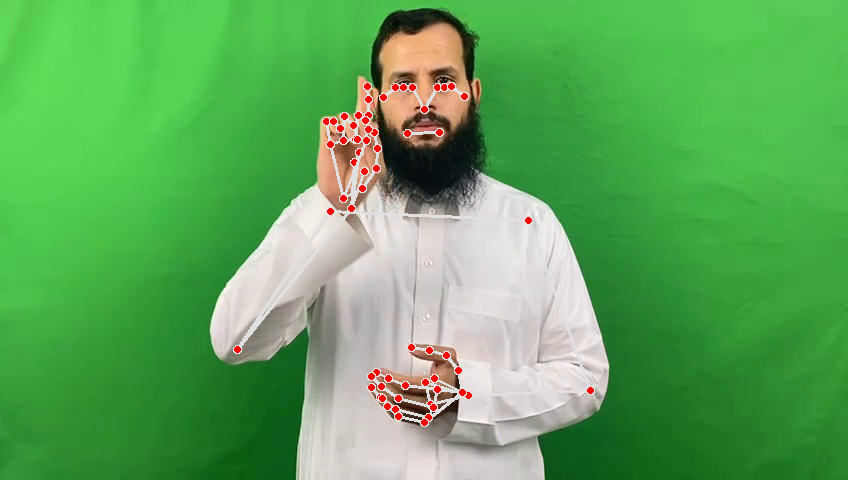

In [ ]:
import os
import json
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def load_keypoints(json_file_path):
    """Load keypoints from a JSON file."""
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def calculate_distance(keypoints1, keypoints2):
    """Calculate Euclidean distance between two sets of keypoints."""
    distance = 0
    count = 0
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:  # For Ensuring both keypoints are not empty
            dist = np.sqrt((kp1['x'] - kp2['x'])**2 + (kp1['y'] - kp2['y'])**2 + (kp1['z'] - kp2['z'])**2)
            distance += dist
            count += 1
    return distance / count if count > 0 else float('inf')

def find_most_similar_frame(keypoints_video1, keypoints_video2):
    """Find the most similar frame in video1 to any frame in video2 based on keypoints."""
    min_distance = float('inf')
    most_similar_pair = (None, None)

    for i, frame1 in enumerate(keypoints_video1):
        for j, frame2 in enumerate(keypoints_video2):
            distance = calculate_distance(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                          frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            if distance < min_distance:
                min_distance = distance
                most_similar_pair = (i, j)

    return most_similar_pair, min_distance

# Paths to the JSON files containing keypoints for each video
json_file_path_video1 = '/content/drive/MyDrive/video_1/keypoints.json'
json_file_path_video2 = '/content/drive/MyDrive/video_2/keypoints.json'

keypoints_video1 = load_keypoints(json_file_path_video1)
keypoints_video2 = load_keypoints(json_file_path_video2)

most_similar_pair, min_distance = find_most_similar_frame(keypoints_video1, keypoints_video2)
print(f"Most similar frame pair: Video1 Frame {most_similar_pair[0]} and Video2 Frame {most_similar_pair[1]} with distance {min_distance}")


frame_path_video1 = f"/content/drive/MyDrive/video_1/frame_{most_similar_pair[0]}.png"
frame_path_video2 = f"/content/drive/MyDrive/video_2/frame_{most_similar_pair[1]}.png"

img1 = cv2.imread(frame_path_video1)
img2 = cv2.imread(frame_path_video2)

cv2_imshow(img1)
cv2_imshow(img2)


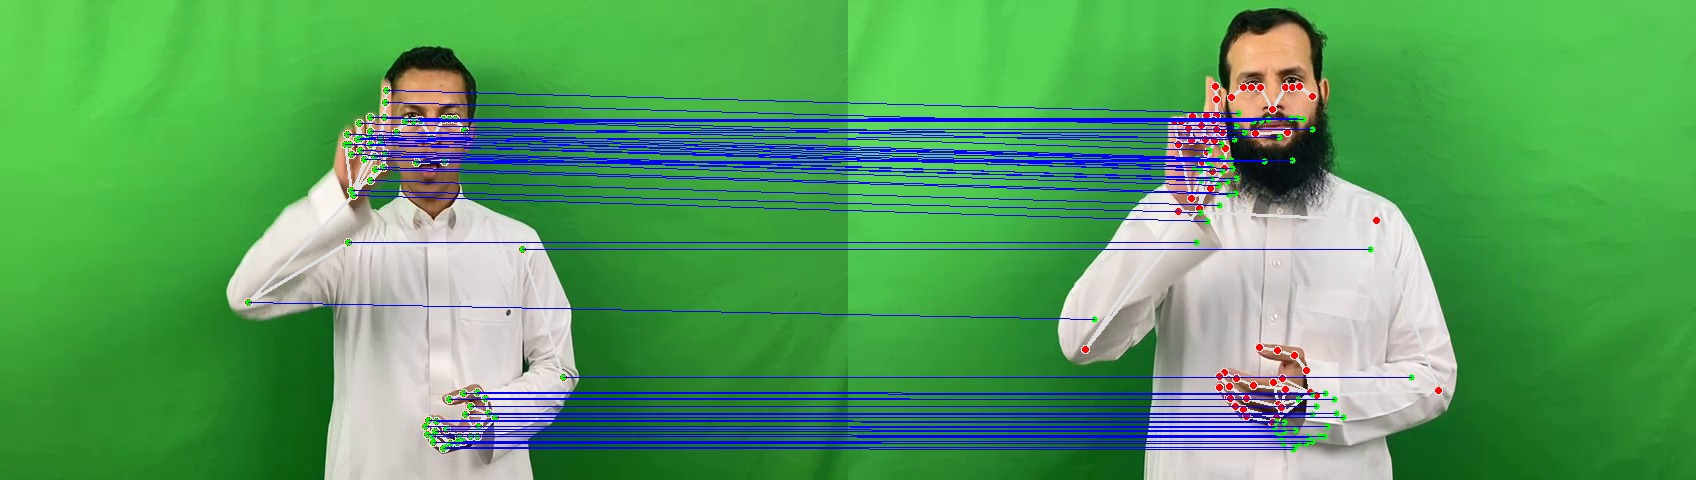

In [ ]:
import cv2
import numpy as np
import json
from google.colab.patches import cv2_imshow

def load_keypoints_from_json(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def draw_keypoints_on_frame(frame, keypoints, color=(0, 255, 0)):
    for kp in keypoints:
        x = int(kp['x'] * frame.shape[1])
        y = int(kp['y'] * frame.shape[0])
        cv2.circle(frame, (x, y), 3, color, -1)
    return frame

def visualize_keypoint_connections(frame1, keypoints1, frame2, keypoints2):
    combined_width = frame1.shape[1] + frame2.shape[1]
    combined_height = max(frame1.shape[0], frame2.shape[0])
    combined_frame = np.zeros((combined_height, combined_width, 3), dtype=np.uint8)

    combined_frame[:frame1.shape[0], :frame1.shape[1]] = frame1
    combined_frame[:frame2.shape[0], frame1.shape[1]:] = frame2

    # Draw lines connecting corresponding keypoints
    for kp1, kp2 in zip(keypoints1, keypoints2):
        x1, y1 = int(kp1['x'] * frame1.shape[1]), int(kp1['y'] * frame1.shape[0])
        x2, y2 = int(kp2['x'] * frame2.shape[1]) + frame1.shape[1], int(kp2['y'] * frame2.shape[0])
        cv2.line(combined_frame, (x1, y1), (x2, y2), (255, 0, 0), 1)

    return combined_frame

# Load keypoints for the most similar frames
keypoints_data_video1 = load_keypoints_from_json('/content/drive/MyDrive/video_1/keypoints.json')
keypoints_data_video2 = load_keypoints_from_json('/content/drive/MyDrive/video_1/keypoints.json')

# Assuming you have the indices of the most similar frames from the above step
most_similar_frame_index_video1 = 23
most_similar_frame_index_video2 = 22

# Read the frames
frame_video1 = cv2.imread(f"/content/drive/MyDrive/video_1/frame_{most_similar_frame_index_video1}.png")
frame_video2 = cv2.imread(f"/content/drive/MyDrive/video_2/frame_{most_similar_frame_index_video2}.png")

# Draw keypoints on frames
frame_with_keypoints_video1 = draw_keypoints_on_frame(frame_video1, keypoints_data_video1[most_similar_frame_index_video1]['keypoints']['pose'] + keypoints_data_video1[most_similar_frame_index_video1]['keypoints']['left_hand'] + keypoints_data_video1[most_similar_frame_index_video1]['keypoints']['right_hand'])
frame_with_keypoints_video2 = draw_keypoints_on_frame(frame_video2, keypoints_data_video2[most_similar_frame_index_video2]['keypoints']['pose'] + keypoints_data_video2[most_similar_frame_index_video2]['keypoints']['left_hand'] + keypoints_data_video2[most_similar_frame_index_video2]['keypoints']['right_hand'])

# Visualize connections
combined_frame = visualize_keypoint_connections(frame_with_keypoints_video1, keypoints_data_video1[most_similar_frame_index_video1]['keypoints']['pose'] + keypoints_data_video1[most_similar_frame_index_video1]['keypoints']['left_hand'] + keypoints_data_video1[most_similar_frame_index_video1]['keypoints']['right_hand'], frame_with_keypoints_video2, keypoints_data_video2[most_similar_frame_index_video2]['keypoints']['pose'] + keypoints_data_video2[most_similar_frame_index_video2]['keypoints']['left_hand'] + keypoints_data_video2[most_similar_frame_index_video2]['keypoints']['right_hand'])

# Show the combined frame with keypoints connections
cv2_imshow(combined_frame)


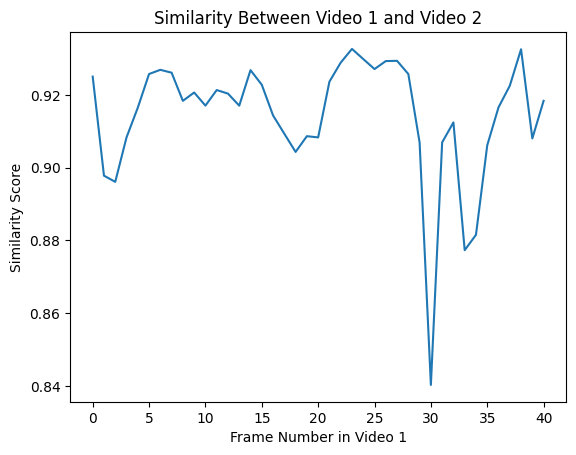

In [ ]:
import os
import json
import numpy as np
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt

def load_keypoints(json_file_path):
    """Load keypoints from a JSON file."""
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def calculate_similarity_score(keypoints1, keypoints2):
    """Calculate similarity score based on Euclidean distance between two sets of keypoints."""
    distances = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:
            dist = euclidean((kp1['x'], kp1['y'], kp1.get('z', 0)), (kp2['x'], kp2['y'], kp2.get('z', 0)))
            distances.append(dist)
    average_distance = sum(distances) / len(distances) if distances else float('inf')
    return 1 / (1 + average_distance)  # Similarity score formula

def compare_videos(video1_keypoints, video2_keypoints):
    """Compare two videos frame-by-frame and calculate similarity scores."""
    similarity_scores = []
    for frame1 in video1_keypoints:
        best_score = 0
        for frame2 in video2_keypoints:
            score = calculate_similarity_score(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                               frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            best_score = max(score, best_score)
        similarity_scores.append(best_score)
    return similarity_scores

# Load keypoints from JSON files
video1_keypoints = load_keypoints('/content/drive/MyDrive/video_1/keypoints.json')
video2_keypoints = load_keypoints('/content/drive/MyDrive/video_2/keypoints.json')

# Calculate similarity scores between two videos
similarity_scores = compare_videos(video1_keypoints, video2_keypoints)


plt.plot(similarity_scores)
plt.xlabel('Frame Number in Video 1')
plt.ylabel('Similarity Score')
plt.title('Similarity Between Video 1 and Video 2')
plt.show()


In [ ]:
!pip install arabic-reshaper
!pip install python-bidi

Overall Similarity Score: 0.86


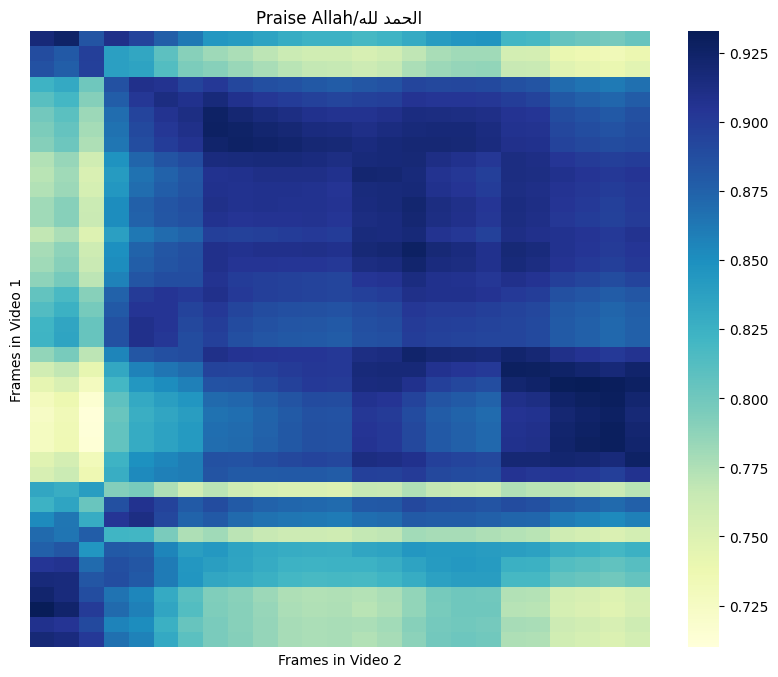

In [ ]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import arabic_reshaper
from bidi.algorithm import get_display

# Load keypoints
def load_keypoints(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

# Calculate similarity score
def calculate_similarity_score(keypoints1, keypoints2):
    distances = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:
            dist = euclidean((kp1['x'], kp1['y'], kp1.get('z', 0)), (kp2['x'], kp2['y'], kp2.get('z', 0)))
            distances.append(dist)
    average_distance = sum(distances) / len(distances) if distances else float('inf')
    return 1 / (1 + average_distance)

# Generate similarity matrix
def generate_similarity_matrix(video1_keypoints, video2_keypoints):
    similarity_matrix = np.zeros((len(video1_keypoints), len(video2_keypoints)))
    for i, frame1 in enumerate(video1_keypoints):
        for j, frame2 in enumerate(video2_keypoints):
            score = calculate_similarity_score(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                               frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            similarity_matrix[i, j] = score
    return similarity_matrix

# Paths for keypoints JSON files
json_file_path_video1 = '/content/drive/MyDrive/video_1/keypoints.json'
json_file_path_video2 = '/content/drive/MyDrive/video_2/keypoints.json'

# Load keypoints data
video1_keypoints = load_keypoints(json_file_path_video1)
video2_keypoints = load_keypoints(json_file_path_video2)

# Generate similarity matrix
similarity_matrix = generate_similarity_matrix(video1_keypoints, video2_keypoints)

# Calculate the overall similarity score for all frames
overall_similarity_score = np.mean(similarity_matrix)
print(f"Overall Similarity Score: {overall_similarity_score:.2f}")



def reshape_arabic(text):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text


plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='YlGnBu', xticklabels=False, yticklabels=False)
plt.title(reshape_arabic('Praise Allah/الحمد لله'))
plt.xlabel(reshape_arabic('Frames in Video 2'))
plt.ylabel(reshape_arabic('Frames in Video 1'))
plt.show()


# **وهو ينتظر حصيلة عمله**

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe solutions
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints_and_pose(pose_results, hands_results):
    """
    Extract pose, left hand, and right hand keypoints from MediaPipe results.
    """
    keypoints = {
        'pose': [],
        'left_hand': [],
        'right_hand': []
    }
    # Extract pose landmarks
    if pose_results.pose_landmarks:
        for landmark in pose_results.pose_landmarks.landmark:
            keypoints['pose'].append({
                'x': landmark.x,
                'y': landmark.y,
                'z': landmark.z,
                'visibility': landmark.visibility
            })
    # Extract left and right hand landmarks
    if hands_results.multi_hand_landmarks:
        for hand_landmarks in hands_results.multi_hand_landmarks:
            hand_type = 'left_hand' if hand_landmarks == hands_results.multi_hand_landmarks[0] else 'right_hand'
            for landmark in hand_landmarks.landmark:
                keypoints[hand_type].append({
                    'x': landmark.x,
                    'y': landmark.y,
                    'z': landmark.z
                })
    return keypoints

def extract_significant_frames_and_keypoints(video_path, save_dir, threshold=0.1):
    """
    Extract significant frames and keypoints (pose, left hand, right hand) from a video.
    """
    cap = cv2.VideoCapture(video_path)
    prev_pose = None
    frame_idx = 0
    keypoints_data = []

    with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose, \
         mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pose_results = pose.process(image_rgb)
            hands_results = hands.process(image_rgb)

            # Draw pose and hands on the image
            mp_drawing.draw_landmarks(image, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
            if hands_results.multi_hand_landmarks:
                for hand_landmarks in hands_results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            if prev_pose and pose_results.pose_landmarks:
                pose_diff = np.sum([abs(a.x - b.x) + abs(a.y - b.y) for a, b in zip(prev_pose.landmark, pose_results.pose_landmarks.landmark)])
                if pose_diff > threshold:
                    frame_save_path = os.path.join(save_dir, f"frame_{frame_idx}.png")
                    cv2.imwrite(frame_save_path, image)
                    keypoints = extract_keypoints_and_pose(pose_results, hands_results)
                    keypoints_data.append({
                        'frame_id': frame_idx,
                        'frame_name': f"frame_{frame_idx}.png",
                        'keypoints': keypoints
                    })
                    frame_idx += 1

            prev_pose = pose_results.pose_landmarks

    cap.release()
    # Save keypoints to JSON file with frame ID and name
    keypoints_file_path = os.path.join(save_dir, "keypoints.json")
    with open(keypoints_file_path, 'w') as f:
        json.dump(keypoints_data, f, indent=4)

#paths for your video files and directories to save frames/keypoints
video_paths = ["/content/drive/MyDrive/ArSL video dataset/وهو ينتظر حصيلة عمله/وهو ينتظر حصيلة عمله 1.mp4",
               "/content/drive/MyDrive/ArSL video dataset/وهو ينتظر حصيلة عمله/وهو ينتظر حصيلة عمله 2.mp4"]
save_dirs = ["/content/drive/MyDrive/وهو ينتظر حصيلة عمله_1", "/content/drive/MyDrive/وهو ينتظر حصيلة عمله_2"]

for video_path, save_dir in zip(video_paths, save_dirs):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    extract_significant_frames_and_keypoints(video_path, save_dir)

Most similar frame pair: Video1 Frame 23 and Video2 Frame 25 with distance 0.050858842622687264


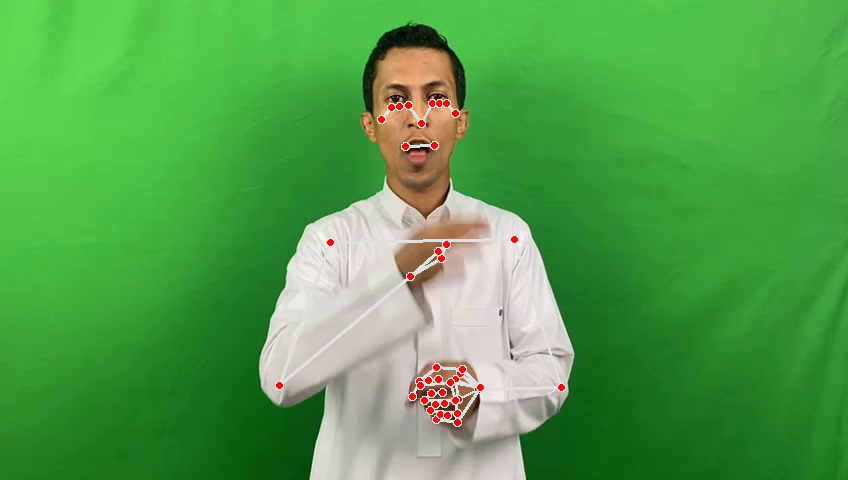

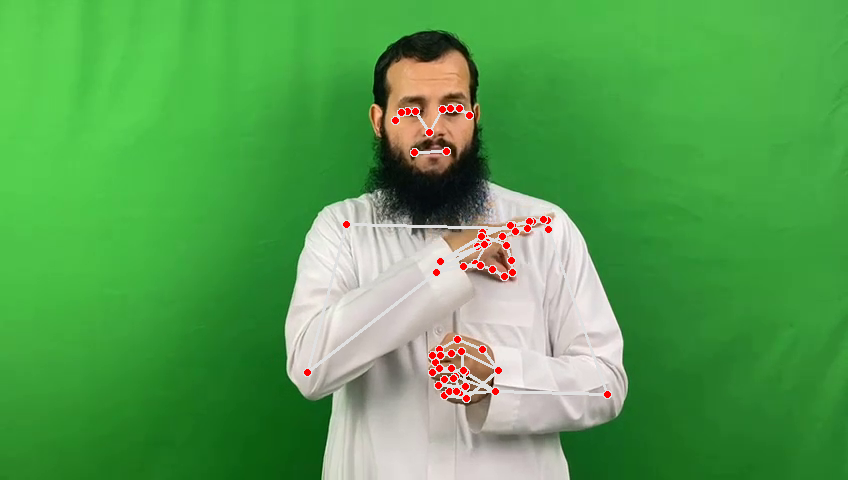

In [ ]:
import os
import json
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Import cv2_imshow

def load_keypoints(json_file_path):
    """Load keypoints from a JSON file."""
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def calculate_distance(keypoints1, keypoints2):
    """Calculate Euclidean distance between two sets of keypoints."""
    distance = 0
    count = 0
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:
            dist = np.sqrt((kp1['x'] - kp2['x'])**2 + (kp1['y'] - kp2['y'])**2 + (kp1['z'] - kp2['z'])**2)
            distance += dist
            count += 1
    return distance / count if count > 0 else float('inf')

def find_most_similar_frame(keypoints_video1, keypoints_video2):
    """Find the most similar frame in video1 to any frame in video2 based on keypoints."""
    min_distance = float('inf')
    most_similar_pair = (None, None)

    for i, frame1 in enumerate(keypoints_video1):
        for j, frame2 in enumerate(keypoints_video2):
            distance = calculate_distance(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                          frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            if distance < min_distance:
                min_distance = distance
                most_similar_pair = (i, j)

    return most_similar_pair, min_distance

# Paths to the JSON files containing keypoints for each video
json_file_path_video1 = '/content/drive/MyDrive/وهو ينتظر حصيلة عمله_1/keypoints.json'
json_file_path_video2 = '/content/drive/MyDrive/وهو ينتظر حصيلة عمله_2/keypoints.json'

keypoints_video1 = load_keypoints(json_file_path_video1)
keypoints_video2 = load_keypoints(json_file_path_video2)

most_similar_pair, min_distance = find_most_similar_frame(keypoints_video1, keypoints_video2)
print(f"Most similar frame pair: Video1 Frame {most_similar_pair[0]} and Video2 Frame {most_similar_pair[1]} with distance {min_distance}")


frame_path_video1 = f"/content/drive/MyDrive/وهو ينتظر حصيلة عمله_1/frame_{most_similar_pair[0]}.png"
frame_path_video2 = f"/content/drive/MyDrive/وهو ينتظر حصيلة عمله_2/frame_{most_similar_pair[1]}.png"

img1 = cv2.imread(frame_path_video1)
img2 = cv2.imread(frame_path_video2)

cv2_imshow(img1)
cv2_imshow(img2)


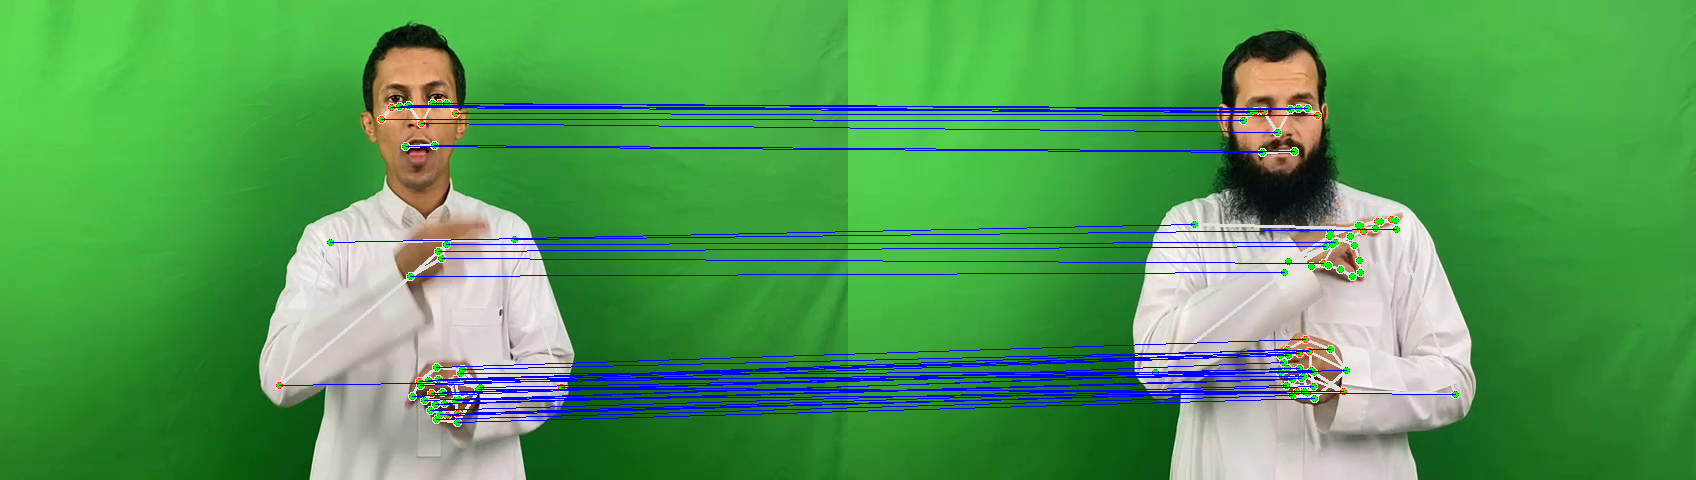

In [ ]:
import cv2
import numpy as np
import json
from google.colab.patches import cv2_imshow  # Use cv2_imshow in Google Colab

def load_keypoints_from_json(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def draw_keypoints_on_frame(frame, keypoints, color=(0, 255, 0)):
    for kp in keypoints:
        x = int(kp['x'] * frame.shape[1])
        y = int(kp['y'] * frame.shape[0])
        cv2.circle(frame, (x, y), 3, color, -1)
    return frame

def visualize_keypoint_connections(frame1, keypoints1, frame2, keypoints2):
    combined_width = frame1.shape[1] + frame2.shape[1]
    combined_height = max(frame1.shape[0], frame2.shape[0])
    combined_frame = np.zeros((combined_height, combined_width, 3), dtype=np.uint8)

    combined_frame[:frame1.shape[0], :frame1.shape[1]] = frame1
    combined_frame[:frame2.shape[0], frame1.shape[1]:] = frame2

    # Draw lines connecting corresponding keypoints
    for kp1, kp2 in zip(keypoints1, keypoints2):
        x1, y1 = int(kp1['x'] * frame1.shape[1]), int(kp1['y'] * frame1.shape[0])
        x2, y2 = int(kp2['x'] * frame2.shape[1]) + frame1.shape[1], int(kp2['y'] * frame2.shape[0])
        cv2.line(combined_frame, (x1, y1), (x2, y2), (255, 0, 0), 1)

    return combined_frame

# Load keypoints for the most similar frames
keypoints_data_video1 = load_keypoints_from_json('/content/drive/MyDrive/وهو ينتظر حصيلة عمله_1/keypoints.json')
keypoints_data_video2 = load_keypoints_from_json('/content/drive/MyDrive/وهو ينتظر حصيلة عمله_2/keypoints.json')

# Assuming you have the indices of the most similar frames
most_similar_frame_index_video1 = 23  # Example index, replace with actual
most_similar_frame_index_video2 = 25  # Example index, replace with actual

# Load the frames
frame_video1 = cv2.imread(f"/content/drive/MyDrive/وهو ينتظر حصيلة عمله_1/frame_{most_similar_frame_index_video1}.png")
frame_video2 = cv2.imread(f"/content/drive/MyDrive/وهو ينتظر حصيلة عمله_2/frame_{most_similar_frame_index_video2}.png")

# Draw keypoints on frames
frame_with_keypoints_video1 = draw_keypoints_on_frame(frame_video1, keypoints_data_video1[most_similar_frame_index_video1]['keypoints']['pose'] + keypoints_data_video1[most_similar_frame_index_video1]['keypoints']['left_hand'] + keypoints_data_video1[most_similar_frame_index_video1]['keypoints']['right_hand'])
frame_with_keypoints_video2 = draw_keypoints_on_frame(frame_video2, keypoints_data_video2[most_similar_frame_index_video2]['keypoints']['pose'] + keypoints_data_video2[most_similar_frame_index_video2]['keypoints']['left_hand'] + keypoints_data_video2[most_similar_frame_index_video2]['keypoints']['right_hand'])

# Visualize connections
combined_frame = visualize_keypoint_connections(frame_with_keypoints_video1, keypoints_data_video1[most_similar_frame_index_video1]['keypoints']['pose'] + keypoints_data_video1[most_similar_frame_index_video1]['keypoints']['left_hand'] + keypoints_data_video1[most_similar_frame_index_video1]['keypoints']['right_hand'], frame_with_keypoints_video2, keypoints_data_video2[most_similar_frame_index_video2]['keypoints']['pose'] + keypoints_data_video2[most_similar_frame_index_video2]['keypoints']['left_hand'] + keypoints_data_video2[most_similar_frame_index_video2]['keypoints']['right_hand'])


cv2_imshow(combined_frame)


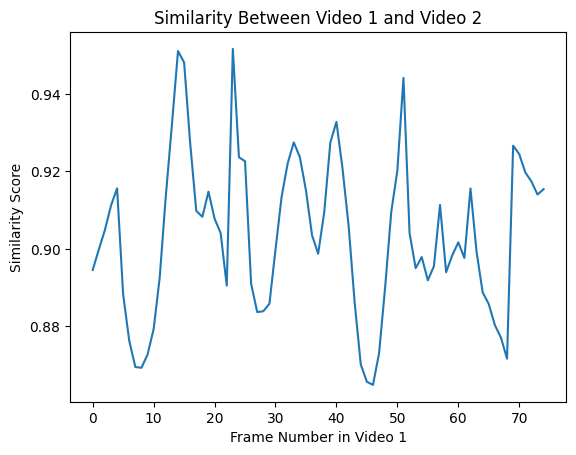

In [ ]:
import os
import json
import numpy as np
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt

def load_keypoints(json_file_path):
    """Load keypoints from a JSON file."""
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def calculate_similarity_score(keypoints1, keypoints2):
    """Calculate similarity score based on Euclidean distance between two sets of keypoints."""
    distances = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:
            dist = euclidean((kp1['x'], kp1['y'], kp1.get('z', 0)), (kp2['x'], kp2['y'], kp2.get('z', 0)))
            distances.append(dist)
    average_distance = sum(distances) / len(distances) if distances else float('inf')
    return 1 / (1 + average_distance)  # Similarity score formula

def compare_videos(video1_keypoints, video2_keypoints):
    """Compare two videos frame-by-frame and calculate similarity scores."""
    similarity_scores = []
    for frame1 in video1_keypoints:
        best_score = 0
        for frame2 in video2_keypoints:
            score = calculate_similarity_score(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                               frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            best_score = max(score, best_score)
        similarity_scores.append(best_score)
    return similarity_scores

# Load keypoints from JSON files
video1_keypoints = load_keypoints('/content/drive/MyDrive/وهو ينتظر حصيلة عمله_1/keypoints.json')
video2_keypoints = load_keypoints('/content/drive/MyDrive/وهو ينتظر حصيلة عمله_2/keypoints.json')

# Calculate similarity scores between two videos
similarity_scores = compare_videos(video1_keypoints, video2_keypoints)

# Plot the similarity scores
plt.plot(similarity_scores)
plt.xlabel('Frame Number in Video 1')
plt.ylabel('Similarity Score')
plt.title('Similarity Between Video 1 and Video 2')
plt.show()


Overall Similarity Score: 0.84


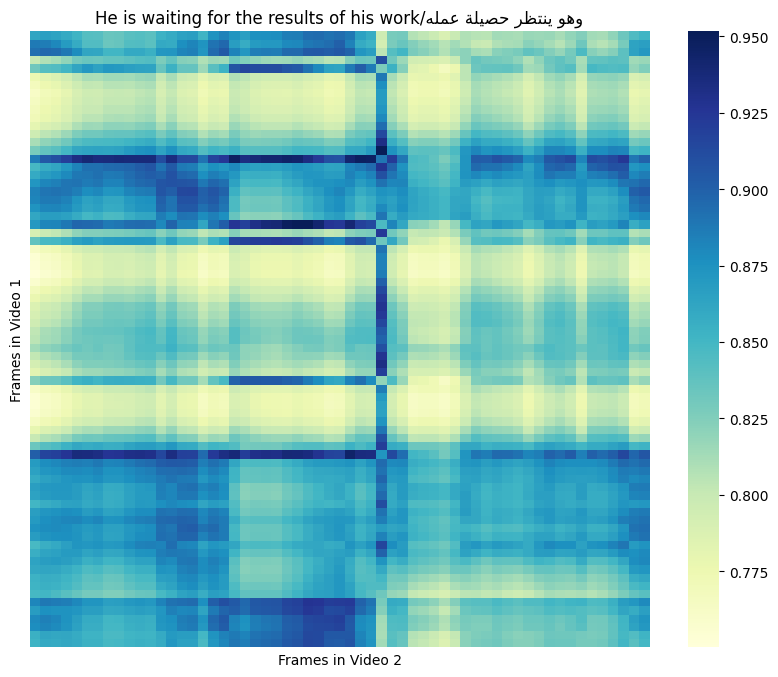

In [ ]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import arabic_reshaper
from bidi.algorithm import get_display

# Load keypoints
def load_keypoints(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

# Calculate similarity score
def calculate_similarity_score(keypoints1, keypoints2):
    distances = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:
            dist = euclidean((kp1['x'], kp1['y'], kp1.get('z', 0)), (kp2['x'], kp2['y'], kp2.get('z', 0)))
            distances.append(dist)
    average_distance = sum(distances) / len(distances) if distances else float('inf')
    return 1 / (1 + average_distance)

# Generate similarity matrix
def generate_similarity_matrix(video1_keypoints, video2_keypoints):
    similarity_matrix = np.zeros((len(video1_keypoints), len(video2_keypoints)))
    for i, frame1 in enumerate(video1_keypoints):
        for j, frame2 in enumerate(video2_keypoints):
            score = calculate_similarity_score(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                               frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            similarity_matrix[i, j] = score
    return similarity_matrix

# Paths for keypoints JSON files
json_file_path_video1 = '/content/drive/MyDrive/وهو ينتظر حصيلة عمله_1/keypoints.json'
json_file_path_video2 = '/content/drive/MyDrive/وهو ينتظر حصيلة عمله_2/keypoints.json'

# Load keypoints data
video1_keypoints = load_keypoints(json_file_path_video1)
video2_keypoints = load_keypoints(json_file_path_video2)

# Generate similarity matrix
similarity_matrix = generate_similarity_matrix(video1_keypoints, video2_keypoints)

# Calculate the overall similarity score for all frames
overall_similarity_score = np.mean(similarity_matrix)
print(f"Overall Similarity Score: {overall_similarity_score:.2f}")


# Function to reshape Arabic text for correct display
def reshape_arabic(text):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text

# Plot the similarity scores using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='YlGnBu', xticklabels=False, yticklabels=False)
plt.title(reshape_arabic('He is waiting for the results of his work/وهو ينتظر حصيلة عمله'))
plt.xlabel(reshape_arabic('Frames in Video 2'))
plt.ylabel(reshape_arabic('Frames in Video 1'))
plt.show()


# **احم حوزة الدين**

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe solutions
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints_and_pose(pose_results, hands_results):
    """
    Extract pose, left hand, and right hand keypoints from MediaPipe results.
    """
    keypoints = {
        'pose': [],
        'left_hand': [],
        'right_hand': []
    }
    # Extract pose landmarks
    if pose_results.pose_landmarks:
        for landmark in pose_results.pose_landmarks.landmark:
            keypoints['pose'].append({
                'x': landmark.x,
                'y': landmark.y,
                'z': landmark.z,
                'visibility': landmark.visibility
            })
    # Extract left and right hand landmarks
    if hands_results.multi_hand_landmarks:
        for hand_landmarks in hands_results.multi_hand_landmarks:
            # Assuming the first detected hand is the left hand and the second is the right hand
            hand_type = 'left_hand' if hand_landmarks == hands_results.multi_hand_landmarks[0] else 'right_hand'
            for landmark in hand_landmarks.landmark:
                keypoints[hand_type].append({
                    'x': landmark.x,
                    'y': landmark.y,
                    'z': landmark.z
                })
    return keypoints

def extract_significant_frames_and_keypoints(video_path, save_dir, threshold=0.1):
    """
    Extract significant frames and keypoints (pose, left hand, right hand) from a video.
    """
    cap = cv2.VideoCapture(video_path)
    prev_pose = None
    frame_idx = 0
    keypoints_data = []

    with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose, \
         mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pose_results = pose.process(image_rgb)
            hands_results = hands.process(image_rgb)

            # Draw pose and hands on the image
            mp_drawing.draw_landmarks(image, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
            if hands_results.multi_hand_landmarks:
                for hand_landmarks in hands_results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            if prev_pose and pose_results.pose_landmarks:
                pose_diff = np.sum([abs(a.x - b.x) + abs(a.y - b.y) for a, b in zip(prev_pose.landmark, pose_results.pose_landmarks.landmark)])
                if pose_diff > threshold:
                    frame_save_path = os.path.join(save_dir, f"frame_{frame_idx}.png")
                    cv2.imwrite(frame_save_path, image)
                    keypoints = extract_keypoints_and_pose(pose_results, hands_results)
                    keypoints_data.append({
                        'frame_id': frame_idx,
                        'frame_name': f"frame_{frame_idx}.png",
                        'keypoints': keypoints
                    })
                    frame_idx += 1

            prev_pose = pose_results.pose_landmarks

    cap.release()
    # Save keypoints to JSON file with frame ID and name
    keypoints_file_path = os.path.join(save_dir, "keypoints.json")
    with open(keypoints_file_path, 'w') as f:
        json.dump(keypoints_data, f, indent=4)

#paths for your video files and directories to save frames/keypoints
video_paths = ["/content/drive/MyDrive/ArSL video dataset/احم حوزة الدين/احم حوزة الدين 1.mp4",
               "/content/drive/MyDrive/ArSL video dataset/احم حوزة الدين/احم حوزة الدين 2.mp4"]
save_dirs = ["/content/drive/MyDrive/احم حوزة الدين_1", "/content/drive/MyDrive/احم حوزة الدين_2"]

for video_path, save_dir in zip(video_paths, save_dirs):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    extract_significant_frames_and_keypoints(video_path, save_dir)

Most similar frame pair: Video1 Frame 3 and Video2 Frame 54 with distance 0.1021509955140133


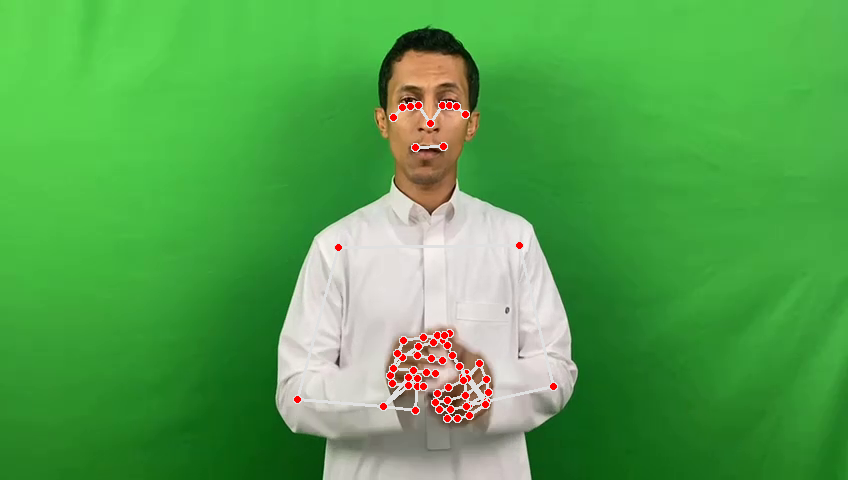

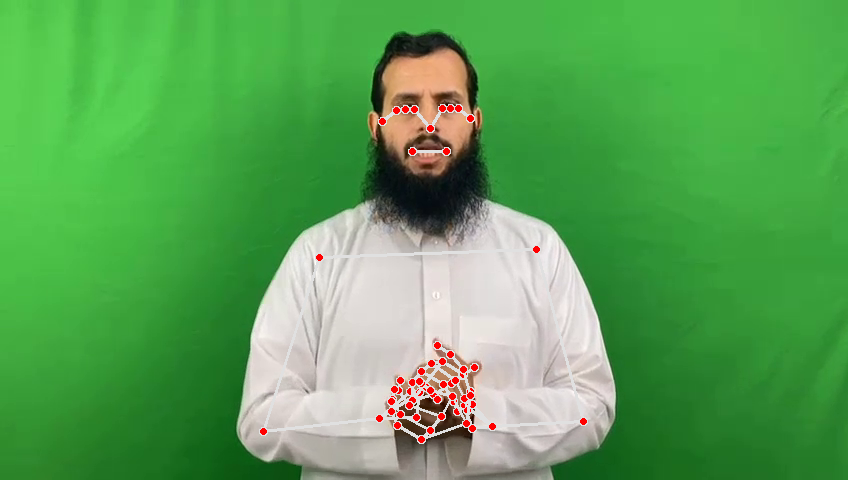

In [ ]:
import os
import json
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def load_keypoints(json_file_path):
    """Load keypoints from a JSON file."""
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def calculate_distance(keypoints1, keypoints2):
    """Calculate Euclidean distance between two sets of keypoints."""
    distance = 0
    count = 0
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:
            dist = np.sqrt((kp1['x'] - kp2['x'])**2 + (kp1['y'] - kp2['y'])**2 + (kp1['z'] - kp2['z'])**2)
            distance += dist
            count += 1
    return distance / count if count > 0 else float('inf')

def find_most_similar_frame(keypoints_video1, keypoints_video2):
    """Find the most similar frame in video1 to any frame in video2 based on keypoints."""
    min_distance = float('inf')
    most_similar_pair = (None, None)

    for i, frame1 in enumerate(keypoints_video1):
        for j, frame2 in enumerate(keypoints_video2):
            distance = calculate_distance(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                          frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            if distance < min_distance:
                min_distance = distance
                most_similar_pair = (i, j)

    return most_similar_pair, min_distance

# Paths to the JSON files containing keypoints for each video
json_file_path_video1 = '/content/drive/MyDrive/احم حوزة الدين_1/keypoints.json'
json_file_path_video2 = '/content/drive/MyDrive/احم حوزة الدين_2/keypoints.json'

keypoints_video1 = load_keypoints(json_file_path_video1)
keypoints_video2 = load_keypoints(json_file_path_video2)

most_similar_pair, min_distance = find_most_similar_frame(keypoints_video1, keypoints_video2)
print(f"Most similar frame pair: Video1 Frame {most_similar_pair[0]} and Video2 Frame {most_similar_pair[1]} with distance {min_distance}")


frame_path_video1 = f"/content/drive/MyDrive/احم حوزة الدين_1/frame_{most_similar_pair[0]}.png"
frame_path_video2 = f"/content/drive/MyDrive/احم حوزة الدين_2/frame_{most_similar_pair[1]}.png"

img1 = cv2.imread(frame_path_video1)
img2 = cv2.imread(frame_path_video2)

cv2_imshow(img1)
cv2_imshow(img2)


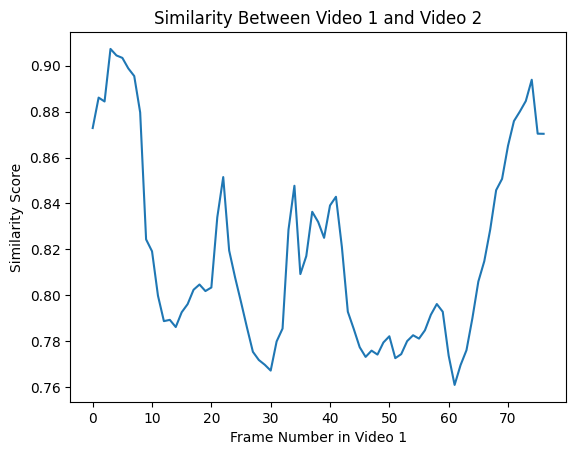

In [ ]:
import os
import json
import numpy as np
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt

def load_keypoints(json_file_path):
    """Load keypoints from a JSON file."""
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def calculate_similarity_score(keypoints1, keypoints2):
    """Calculate similarity score based on Euclidean distance between two sets of keypoints."""
    distances = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:
            dist = euclidean((kp1['x'], kp1['y'], kp1.get('z', 0)), (kp2['x'], kp2['y'], kp2.get('z', 0)))
            distances.append(dist)
    average_distance = sum(distances) / len(distances) if distances else float('inf')
    return 1 / (1 + average_distance)  # Similarity score formula

def compare_videos(video1_keypoints, video2_keypoints):
    """Compare two videos frame-by-frame and calculate similarity scores."""
    similarity_scores = []
    for frame1 in video1_keypoints:
        best_score = 0
        for frame2 in video2_keypoints:
            score = calculate_similarity_score(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                               frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            best_score = max(score, best_score)
        similarity_scores.append(best_score)
    return similarity_scores

# Load keypoints from JSON files
video1_keypoints = load_keypoints('/content/drive/MyDrive/احم حوزة الدين_1/keypoints.json')
video2_keypoints = load_keypoints('/content/drive/MyDrive/احم حوزة الدين_2/keypoints.json')

# Calculate similarity scores between two videos
similarity_scores = compare_videos(video1_keypoints, video2_keypoints)

# Plot the similarity scores
plt.plot(similarity_scores)
plt.xlabel('Frame Number in Video 1')
plt.ylabel('Similarity Score')
plt.title('Similarity Between Video 1 and Video 2')
plt.show()


Overall Similarity Score: 0.78


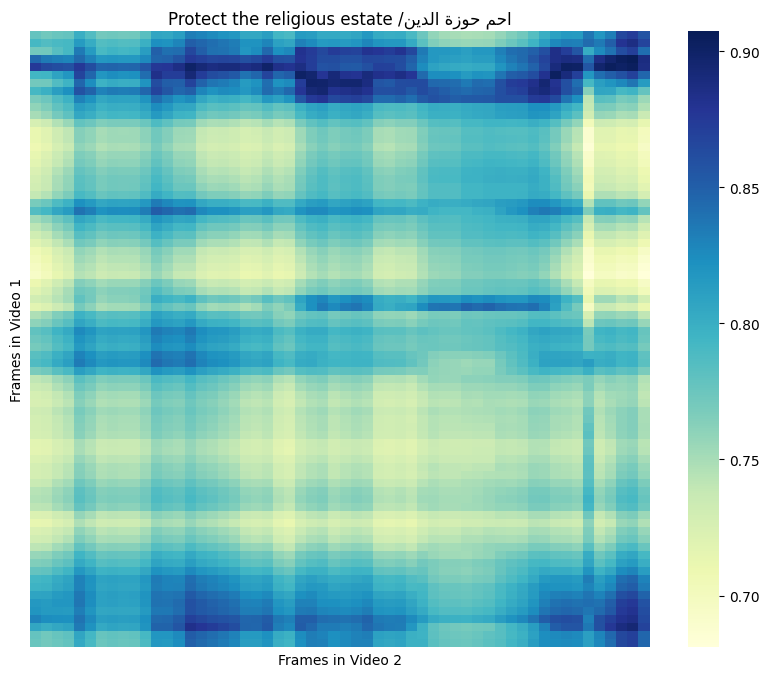

In [ ]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import arabic_reshaper
from bidi.algorithm import get_display

# Load keypoints
def load_keypoints(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

# Calculate similarity score
def calculate_similarity_score(keypoints1, keypoints2):
    distances = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:
            dist = euclidean((kp1['x'], kp1['y'], kp1.get('z', 0)), (kp2['x'], kp2['y'], kp2.get('z', 0)))
            distances.append(dist)
    average_distance = sum(distances) / len(distances) if distances else float('inf')
    return 1 / (1 + average_distance)

# Generate similarity matrix
def generate_similarity_matrix(video1_keypoints, video2_keypoints):
    similarity_matrix = np.zeros((len(video1_keypoints), len(video2_keypoints)))
    for i, frame1 in enumerate(video1_keypoints):
        for j, frame2 in enumerate(video2_keypoints):
            score = calculate_similarity_score(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                               frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            similarity_matrix[i, j] = score
    return similarity_matrix

# Paths for keypoints JSON files
json_file_path_video1 = '/content/drive/MyDrive/احم حوزة الدين_1/keypoints.json'
json_file_path_video2 = '/content/drive/MyDrive/احم حوزة الدين_2/keypoints.json'

# Load keypoints data
video1_keypoints = load_keypoints(json_file_path_video1)
video2_keypoints = load_keypoints(json_file_path_video2)

# Generate similarity matrix
similarity_matrix = generate_similarity_matrix(video1_keypoints, video2_keypoints)

# Calculate the overall similarity score for all frames
overall_similarity_score = np.mean(similarity_matrix)
print(f"Overall Similarity Score: {overall_similarity_score:.2f}")



def reshape_arabic(text):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text


plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='YlGnBu', xticklabels=False, yticklabels=False)
plt.title(reshape_arabic('Protect the religious estate /احم حوزة الدين'))
plt.xlabel(reshape_arabic('Frames in Video 2'))
plt.ylabel(reshape_arabic('Frames in Video 1'))
plt.show()


# **اللهم أجرنا من خزي الدنيا وعذاب الآخرة**

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe solutions
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints_and_pose(pose_results, hands_results):
    """
    Extract pose, left hand, and right hand keypoints from MediaPipe results.
    """
    keypoints = {
        'pose': [],
        'left_hand': [],
        'right_hand': []
    }
    # Extract pose landmarks
    if pose_results.pose_landmarks:
        for landmark in pose_results.pose_landmarks.landmark:
            keypoints['pose'].append({
                'x': landmark.x,
                'y': landmark.y,
                'z': landmark.z,
                'visibility': landmark.visibility
            })
    # Extract left and right hand landmarks
    if hands_results.multi_hand_landmarks:
        for hand_landmarks in hands_results.multi_hand_landmarks:
            hand_type = 'left_hand' if hand_landmarks == hands_results.multi_hand_landmarks[0] else 'right_hand'
            for landmark in hand_landmarks.landmark:
                keypoints[hand_type].append({
                    'x': landmark.x,
                    'y': landmark.y,
                    'z': landmark.z
                })
    return keypoints

def extract_significant_frames_and_keypoints(video_path, save_dir, threshold=0.1):
    """
    Extract significant frames and keypoints (pose, left hand, right hand) from a video.
    """
    cap = cv2.VideoCapture(video_path)
    prev_pose = None
    frame_idx = 0
    keypoints_data = []

    with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose, \
         mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pose_results = pose.process(image_rgb)
            hands_results = hands.process(image_rgb)

            # Draw pose and hands on the image
            mp_drawing.draw_landmarks(image, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
            if hands_results.multi_hand_landmarks:
                for hand_landmarks in hands_results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            if prev_pose and pose_results.pose_landmarks:
                pose_diff = np.sum([abs(a.x - b.x) + abs(a.y - b.y) for a, b in zip(prev_pose.landmark, pose_results.pose_landmarks.landmark)])
                if pose_diff > threshold:
                    frame_save_path = os.path.join(save_dir, f"frame_{frame_idx}.png")
                    cv2.imwrite(frame_save_path, image)
                    keypoints = extract_keypoints_and_pose(pose_results, hands_results)
                    keypoints_data.append({
                        'frame_id': frame_idx,
                        'frame_name': f"frame_{frame_idx}.png",
                        'keypoints': keypoints
                    })
                    frame_idx += 1

            prev_pose = pose_results.pose_landmarks

    cap.release()
    # Save keypoints to JSON file with frame ID and name
    keypoints_file_path = os.path.join(save_dir, "keypoints.json")
    with open(keypoints_file_path, 'w') as f:
        json.dump(keypoints_data, f, indent=4)

#paths for your video files and directories to save frames/keypoints
video_paths = ["/content/drive/MyDrive/ArSL video dataset/أجرنا من خزي الدنيا وعذاب الآخرة/أجرنا من خزي الدنيا وعذاب الآخرة 1.mp4",
               "/content/drive/MyDrive/ArSL video dataset/أجرنا من خزي الدنيا وعذاب الآخرة/أجرنا من خزي الدنيا وعذاب الآخرة 2.mp4"]
save_dirs = ["/content/drive/MyDrive/أجرنا من خزي الدنيا وعذاب الآخرة_1", "/content/drive/MyDrive/أجرنا من خزي الدنيا وعذاب الآخرة_2"]

for video_path, save_dir in zip(video_paths, save_dirs):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    extract_significant_frames_and_keypoints(video_path, save_dir)

Most similar frame pair: Video1 Frame 9 and Video2 Frame 10 with distance 0.06181287090169159


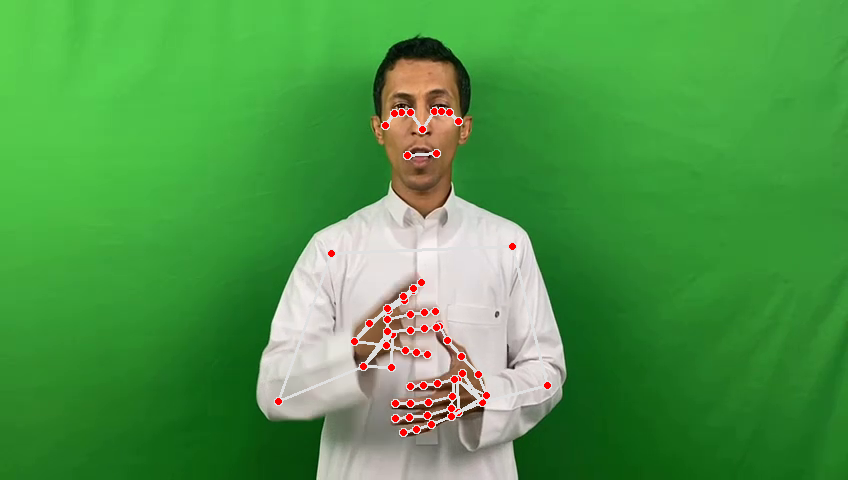

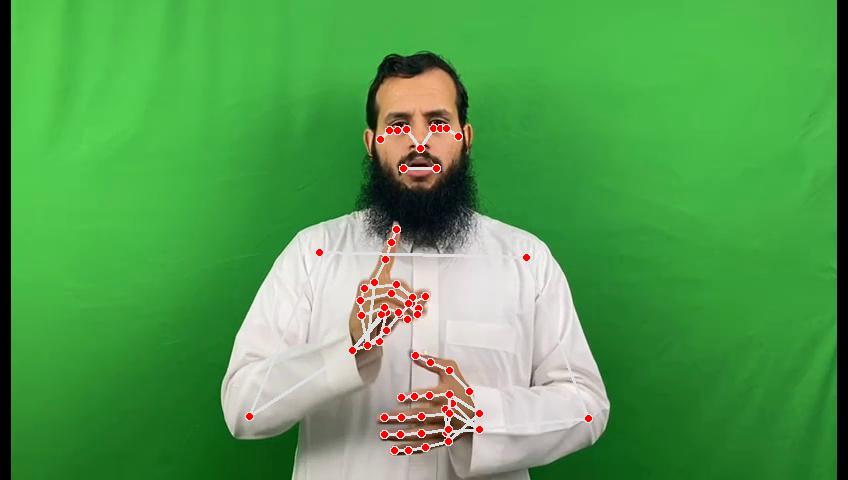

In [ ]:
import os
import json
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Import cv2_imshow

def load_keypoints(json_file_path):
    """Load keypoints from a JSON file."""
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def calculate_distance(keypoints1, keypoints2):
    """Calculate Euclidean distance between two sets of keypoints."""
    distance = 0
    count = 0
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:
            dist = np.sqrt((kp1['x'] - kp2['x'])**2 + (kp1['y'] - kp2['y'])**2 + (kp1['z'] - kp2['z'])**2)
            distance += dist
            count += 1
    return distance / count if count > 0 else float('inf')

def find_most_similar_frame(keypoints_video1, keypoints_video2):
    """Find the most similar frame in video1 to any frame in video2 based on keypoints."""
    min_distance = float('inf')
    most_similar_pair = (None, None)

    for i, frame1 in enumerate(keypoints_video1):
        for j, frame2 in enumerate(keypoints_video2):
            distance = calculate_distance(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                          frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            if distance < min_distance:
                min_distance = distance
                most_similar_pair = (i, j)

    return most_similar_pair, min_distance

# Paths to the JSON files containing keypoints for each video
json_file_path_video1 = '/content/drive/MyDrive/أجرنا من خزي الدنيا وعذاب الآخرة_1/keypoints.json'
json_file_path_video2 = '/content/drive/MyDrive/أجرنا من خزي الدنيا وعذاب الآخرة_2/keypoints.json'

keypoints_video1 = load_keypoints(json_file_path_video1)
keypoints_video2 = load_keypoints(json_file_path_video2)

most_similar_pair, min_distance = find_most_similar_frame(keypoints_video1, keypoints_video2)
print(f"Most similar frame pair: Video1 Frame {most_similar_pair[0]} and Video2 Frame {most_similar_pair[1]} with distance {min_distance}")


frame_path_video1 = f"/content/drive/MyDrive/أجرنا من خزي الدنيا وعذاب الآخرة_1/frame_{most_similar_pair[0]}.png"
frame_path_video2 = f"/content/drive/MyDrive/أجرنا من خزي الدنيا وعذاب الآخرة_2/frame_{most_similar_pair[1]}.png"

img1 = cv2.imread(frame_path_video1)
img2 = cv2.imread(frame_path_video2)

cv2_imshow(img1)
cv2_imshow(img2)


In [ ]:
import os
import json
import numpy as np
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt

def load_keypoints(json_file_path):
    """Load keypoints from a JSON file."""
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def calculate_similarity_score(keypoints1, keypoints2):
    """Calculate similarity score based on Euclidean distance between two sets of keypoints."""
    distances = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:
            dist = euclidean((kp1['x'], kp1['y'], kp1.get('z', 0)), (kp2['x'], kp2['y'], kp2.get('z', 0)))
            distances.append(dist)
    average_distance = sum(distances) / len(distances) if distances else float('inf')
    return 1 / (1 + average_distance)  # Similarity score formula

def compare_videos(video1_keypoints, video2_keypoints):
    """Compare two videos frame-by-frame and calculate similarity scores."""
    similarity_scores = []
    for frame1 in video1_keypoints:
        best_score = 0
        for frame2 in video2_keypoints:
            score = calculate_similarity_score(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                               frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            best_score = max(score, best_score)
        similarity_scores.append(best_score)
    return similarity_scores

# Load keypoints from JSON files
video1_keypoints = load_keypoints('/content/drive/MyDrive/اللهم أجرنا من خزي الدنيا وعذاب الآخرة_1/keypoints.json')
video2_keypoints = load_keypoints('/content/drive/MyDrive/اللهم أجرنا من خزي الدنيا وعذاب الآخرة_2/keypoints.json')

# Calculate similarity scores between two videos
similarity_scores = compare_videos(video1_keypoints, video2_keypoints)


plt.plot(similarity_scores)
plt.xlabel('Frame Number in Video 1')
plt.ylabel('Similarity Score')
plt.title('Similarity Between Video 1 and Video 2')
plt.show()


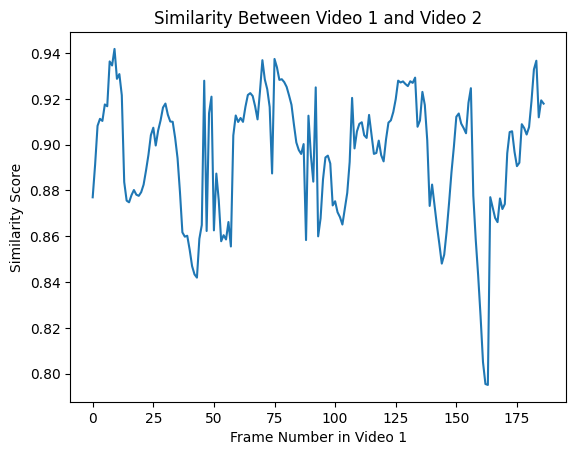

In [ ]:
import os
import json
import numpy as np
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt

def load_keypoints(json_file_path):
    """Load keypoints from a JSON file."""
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def calculate_similarity_score(keypoints1, keypoints2):
    """Calculate similarity score based on Euclidean distance between two sets of keypoints."""
    distances = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:
            dist = euclidean((kp1['x'], kp1['y'], kp1.get('z', 0)), (kp2['x'], kp2['y'], kp2.get('z', 0)))
            distances.append(dist)
    average_distance = sum(distances) / len(distances) if distances else float('inf')
    return 1 / (1 + average_distance)  # Similarity score formula

def compare_videos(video1_keypoints, video2_keypoints):
    """Compare two videos frame-by-frame and calculate similarity scores."""
    similarity_scores = []
    for frame1 in video1_keypoints:
        best_score = 0
        for frame2 in video2_keypoints:
            score = calculate_similarity_score(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                               frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            best_score = max(score, best_score)
        similarity_scores.append(best_score)
    return similarity_scores

# Load keypoints from JSON files
video1_keypoints = load_keypoints('/content/drive/MyDrive/أجرنا من خزي الدنيا وعذاب الآخرة_1/keypoints.json')
video2_keypoints = load_keypoints('/content/drive/MyDrive/أجرنا من خزي الدنيا وعذاب الآخرة_2/keypoints.json')

# Calculate similarity scores between two videos
similarity_scores = compare_videos(video1_keypoints, video2_keypoints)


plt.plot(similarity_scores)
plt.xlabel('Frame Number in Video 1')
plt.ylabel('Similarity Score')
plt.title('Similarity Between Video 1 and Video 2')
plt.show()


Overall Similarity Score: 0.83


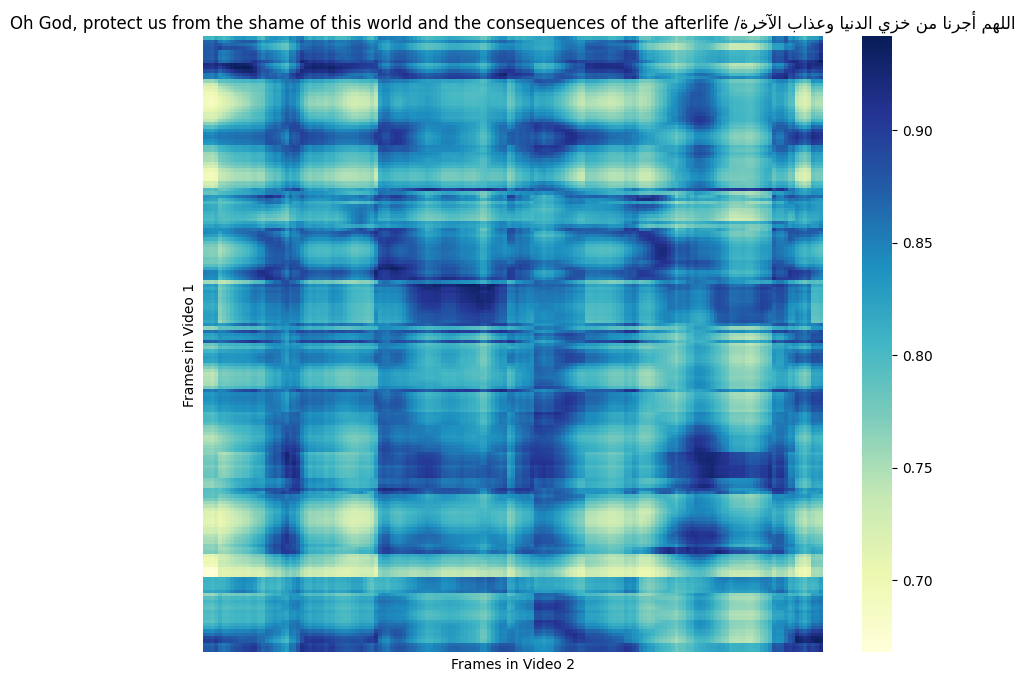

In [ ]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import arabic_reshaper
from bidi.algorithm import get_display

# Load keypoints
def load_keypoints(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

# Calculate similarity score
def calculate_similarity_score(keypoints1, keypoints2):
    distances = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 and kp2:
            dist = euclidean((kp1['x'], kp1['y'], kp1.get('z', 0)), (kp2['x'], kp2['y'], kp2.get('z', 0)))
            distances.append(dist)
    average_distance = sum(distances) / len(distances) if distances else float('inf')
    return 1 / (1 + average_distance)

# Generate similarity matrix
def generate_similarity_matrix(video1_keypoints, video2_keypoints):
    similarity_matrix = np.zeros((len(video1_keypoints), len(video2_keypoints)))
    for i, frame1 in enumerate(video1_keypoints):
        for j, frame2 in enumerate(video2_keypoints):
            score = calculate_similarity_score(frame1['keypoints']['pose'] + frame1['keypoints']['left_hand'] + frame1['keypoints']['right_hand'],
                                               frame2['keypoints']['pose'] + frame2['keypoints']['left_hand'] + frame2['keypoints']['right_hand'])
            similarity_matrix[i, j] = score
    return similarity_matrix

# Paths for keypoints JSON files
json_file_path_video1 = '/content/drive/MyDrive/أجرنا من خزي الدنيا وعذاب الآخرة_1/keypoints.json'
json_file_path_video2 = '/content/drive/MyDrive/أجرنا من خزي الدنيا وعذاب الآخرة_2/keypoints.json'

# Load keypoints data
video1_keypoints = load_keypoints(json_file_path_video1)
video2_keypoints = load_keypoints(json_file_path_video2)

# Generate similarity matrix
similarity_matrix = generate_similarity_matrix(video1_keypoints, video2_keypoints)

# Calculate the overall similarity score for all frames
overall_similarity_score = np.mean(similarity_matrix)
print(f"Overall Similarity Score: {overall_similarity_score:.2f}")


def reshape_arabic(text):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text


plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='YlGnBu', xticklabels=False, yticklabels=False)
plt.title(reshape_arabic('Oh God, protect us from the shame of this world and the consequences of the afterlife /اللهم أجرنا من خزي الدنيا وعذاب الآخرة'))
plt.xlabel(reshape_arabic('Frames in Video 2'))
plt.ylabel(reshape_arabic('Frames in Video 1'))
plt.show()


# **Gloss differences between two signers**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Gloss Similarities Evaluation using Jaccard Sim**

Average Jaccard Similarity across all phrases: 0.85
                               Spoken  \
0                             اما بعد   
1                           الحمد لله   
2                           عباد الله   
3                         أمة الإسلام   
4                        إخوة الإيمان   
..                                ...   
126           فيهما من الآيات والحكمة   
127             نعوذ بك من زوال نعمتك   
128    أصلح أحوال المسلمين في كل مكان   
129  أجرنا من خزي الدنيا وعذاب الآخرة   
130      سبحان ربك رب العزة عما يصفون   

                                     Gloss of signer 1  \
0                                                  بعد   
1                                         الحمد + الله   
2                                         عبادة + الله   
3                                           حزب + مسلم   
4                                            أخ + مؤمن   
..                                                 ...   
126                             في + قرآن + آية +

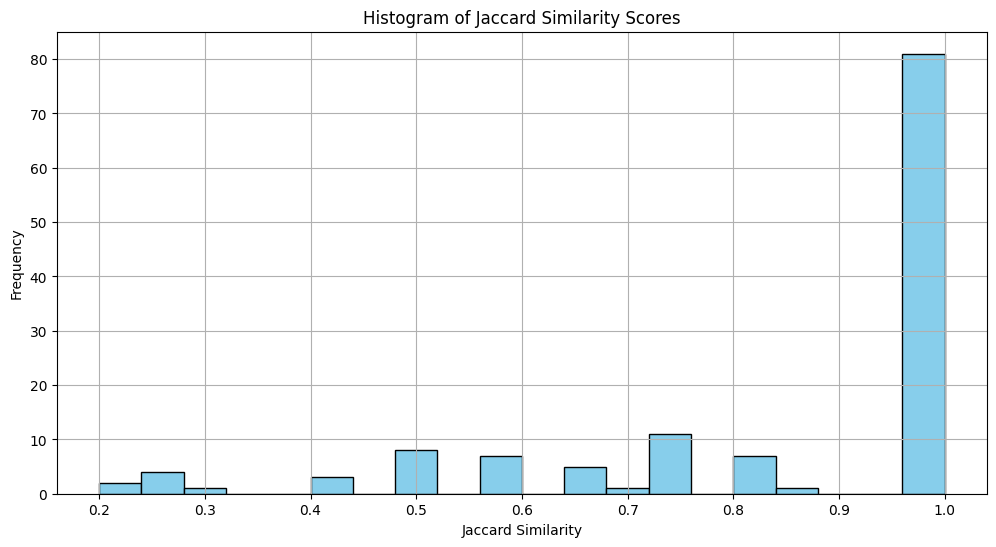

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your Excel file into a pandas DataFrame
df = pd.read_excel('/content/drive/MyDrive/gloss notation with +.xlsx')

# Function to convert gloss entries to a set of words
def gloss_to_set(gloss):
    words = gloss.lower().strip().split('+')
    return set(word.strip() for word in words)

# Apply the function to each gloss column
df['Set of Gloss 1'] = df['Gloss of signer 1'].apply(gloss_to_set)
df['Set of Gloss 2'] = df['Gloss of signer 2'].apply(gloss_to_set)

# Function to calculate Jaccard similarity
def calculate_jaccard(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0
    return len(intersection) / len(union)

# Calculate the Jaccard similarity for each row
df['Jaccard Similarity'] = df.apply(lambda x: calculate_jaccard(x['Set of Gloss 1'], x['Set of Gloss 2']), axis=1)

# Calculate the average similarity
average_similarity = df['Jaccard Similarity'].mean()

# Print the results
print(f'Average Jaccard Similarity across all phrases: {average_similarity:.2f}')
print(df[['Spoken', 'Gloss of signer 1', 'Gloss of signer 2', 'Jaccard Similarity']])

# Save the results to an Excel file
output_path = '/content/drive/MyDrive/similarity_results.xlsx'
df.to_excel(output_path, index=False, sheet_name='Similarity Results')
print(f'Results saved to {output_path}')

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(df['Jaccard Similarity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Jaccard Similarity Scores')
plt.xlabel('Jaccard Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
